In [14]:
import cv2
import numpy as np
import os
import string

In [16]:
# Assuming all images are named "SignatureSet_01.jpg" to "SignatureSet_16.jpg" and are in the "Data" directory
image_dir = 'Data'
output_dir = 'Processed_Images'  # Directory to save all processed bounding box images
image_prefix = 'SignatureSet_'
image_extension = '.jpg'

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [18]:

# Function to process each image
def process_image(image_path, img_num, folder_count):
    img = cv2.imread(image_path)

    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Denoise the image
    denoised_image = cv2.medianBlur(gray, 5)

    # Step 3: Threshold the image to create a binary image
    _, thresholded_image = cv2.threshold(denoised_image, 128, 255, cv2.THRESH_BINARY_INV)

    # Step 4: Dilate the image to strengthen the signature contours
    dilated_image = cv2.dilate(thresholded_image, None, iterations=9)

    # Step 5: Find contours in the image
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Step 6: Draw the contours on the original image
    img_with_contours = img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)  # Green color

    # Step 7: Extract bounding boxes
    bounding_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:  # Filter small contours
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))

    # Merging bounding boxes logic
    merged_bounding_boxes = []

    def boxes_overlap(bb1, bb2):
        x1, y1, w1, h1 = bb1
        x2, y2, w2, h2 = bb2
        return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

    def box_inside(bb1, bb2):
        x1, y1, w1, h1 = bb1
        x2, y2, w2, h2 = bb2
        return x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2)

    # Merge and filter bounding boxes
    for bb in bounding_boxes:
        x, y, w, h = bb
        merged = False
        
        for i, ob in enumerate(merged_bounding_boxes):
            ox, oy, ow, oh = ob
            
            if boxes_overlap(bb, ob) and (w <= 1000 or h <= 500 or ow <= 1000 or oh <= 500):
                new_x = min(x, ox)
                new_y = min(y, oy)
                new_w = max(x + w, ox + ow) - new_x
                new_h = max(y + h, oy + oh) - new_y
                merged_bounding_boxes[i] = (new_x, new_y, new_w, new_h)
                merged = True
                break
        
        if not merged:
            if (w * h) > 90000 and (w * h) < 800000:  
                merged_bounding_boxes.append((x, y, w, h))

    # Filter out bounding boxes inside others
    filtered_bounding_boxes = []
    for i, bb1 in enumerate(merged_bounding_boxes):
        inside_any = False
        for j, bb2 in enumerate(merged_bounding_boxes):
            if i != j and box_inside(bb1, bb2):
                inside_any = True
                break
        if not inside_any:
            filtered_bounding_boxes.append(bb1)


    if len(filtered_bounding_boxes) % 5 == 0:
        for i in range(0, len(filtered_bounding_boxes), 5):
            # Create a folder for every set of 5 bounding boxes
            folder_num = folder_count
            folder_name = f'{output_dir}/{folder_num}'
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)

            # Save each bounding box as an individual image within the current folder
            labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']
            idx = 0
            for new_box in filtered_bounding_boxes[i+1:i+5]:
                # Crop the image as usual
                new_x, new_y, new_w, new_h = new_box
                cropped_img = img[new_y:new_y + new_h, new_x:new_x + new_w]
                gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
                _, binary_cropped_img = cv2.threshold(gray_cropped_img, 128, 255, cv2.THRESH_BINARY)
                box_img_filename = f'{folder_name}/{folder_num}_{labels[idx]}.jpg'
                cv2.imwrite(box_img_filename, binary_cropped_img)

                idx += 1
                            
            folder_count += 1
    elif len(filtered_bounding_boxes) % 4 == 0:
        for i in range(0, len(filtered_bounding_boxes), 4):
            # Create a folder for every set of 5 bounding boxes
            folder_num = folder_count
            folder_name = f'{output_dir}/{folder_num}'
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)

            # Save each bounding box as an individual image within the current folder
            labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']
            idx = 0
            for new_box in filtered_bounding_boxes[i:i+4]:
                new_x, new_y, new_w, new_h = new_box
                cropped_img = img[new_y:new_y + new_h, new_x:new_x + new_w]
                gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)         
                _, binary_cropped_img = cv2.threshold(gray_cropped_img, 128, 255, cv2.THRESH_BINARY)
                # Save the binary image
                box_img_filename = f'{folder_name}/{folder_num}_{labels[idx]}.jpg'
                cv2.imwrite(box_img_filename, binary_cropped_img)

                idx += 1
                            
            folder_count += 1
        

    return folder_count

In [20]:
# Loop through image set 01 to 16
folder_counter = 1
for i in range(1, 17):
    image_filename = f'{image_prefix}{str(i).zfill(2)}{image_extension}'
    image_path = os.path.join(image_dir, image_filename)
    
    print(f'Processing {image_filename}...')
    folder_counter = process_image(image_path, i, folder_counter)


Processing SignatureSet_01.jpg...
Processing SignatureSet_02.jpg...
Processing SignatureSet_03.jpg...
Processing SignatureSet_04.jpg...
Processing SignatureSet_05.jpg...
Processing SignatureSet_06.jpg...
Processing SignatureSet_07.jpg...
Processing SignatureSet_08.jpg...
Processing SignatureSet_09.jpg...
Processing SignatureSet_10.jpg...
Processing SignatureSet_11.jpg...
Processing SignatureSet_12.jpg...
Processing SignatureSet_13.jpg...
Processing SignatureSet_14.jpg...
Processing SignatureSet_15.jpg...
Processing SignatureSet_16.jpg...


In [24]:
import os
import shutil
import math



In [35]:

# Define paths
source_dir = 'Processed_Images'  # This is your original directory containing subfolders
train_dir = 'Processed_Images_Train'
val_dir = 'Processed_Images_Val'
test_dir = 'Processed_Images_Test'

# Create train, val, and test directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Loop through each subfolder (each class)
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    
    # Make directories for each class in train, val, and test folders
    train_class_dir = os.path.join(train_dir, class_folder)
    val_class_dir = os.path.join(val_dir, class_folder)
    test_class_dir = os.path.join(test_dir, class_folder)
    
    for dir_path in [train_class_dir, val_class_dir, test_class_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
    
    # Get list of images in the current class folder
    images = sorted(os.listdir(class_path))  # Ensure images are sorted by name
    
    # Calculate the split indices for 70% train, 15% validation, and 15% test
    total_images = len(images)
    train_split = math.floor(0.7 * total_images)  # 70% for training
    val_split = math.floor(0.85 * total_images)   # 70% + 15% = 85% for train + val
    
    # Move 70% of the images to the train directory
    for img in images[:train_split]:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dest_path)
    
    # Move the next 15% of the images to the validation directory
    for img in images[train_split:val_split]:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(val_class_dir, img)
        shutil.copy(src_path, dest_path)
    
    # Move the remaining 15% of the images to the test directory
    for img in images[val_split:]:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dest_path)
    
print("Data successfully split into 70% training, 15% validation, and 15% testing sets.")


Data successfully split into 70% training, 15% validation, and 15% testing sets.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os


In [ ]:
# Define paths for the training, validation, and testing image directories
train_dir = 'Processed_Images_Train'
val_dir = 'Processed_Images_Val'
test_dir = 'Processed_Images_Test'

In [ ]:


# Data augmentation for training images to enhance model robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Data augmentation for validation and test images (only rescaling, no other transformations)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load the training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated to 224x224 for more feature extraction
    batch_size=32,  # Increased batch size
    class_mode='categorical'
)

# Load the validation images
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

#Load the testing images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

In [45]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(184, activation='softmax')
])


# Define the optimizer with a learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
#model.summary()

# Early stopping and learning rate scheduler callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=100,  # Increased epochs to give more training time
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')



Found 368 images belonging to 184 classes.
Found 184 images belonging to 184 classes.
Found 184 images belonging to 184 classes.
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.0068 - loss: 5.3579 - val_accuracy: 0.0063 - val_loss: 5.2293
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.0000e+00 - loss: 5.1994

C:\Users\muham\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0000e+00 - loss: 5.1994 - val_accuracy: 0.0000e+00 - val_loss: 5.2626
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0032 - loss: 5.2851 - val_accuracy: 0.0125 - val_loss: 5.2178
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0000e+00 - loss: 5.2992 - val_accuracy: 0.0000e+00 - val_loss: 5.2239
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.0000e+00 - loss: 5.2297 - val_accuracy: 0.0063 - val_loss: 5.2147
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0312 - loss: 5.2061 - val_accuracy: 0.0417 - val_loss: 5.2034
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0014 - loss: 5.2124 - val_accuracy: 0.0063 - val_loss: 5.2113
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 5.1944 - val_accuracy: 0.0000e+00 - val_loss: 5.2134
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0000e+00 - loss: 5.2184 - 

In [ ]:
model.save('signature_classification_model.h5')

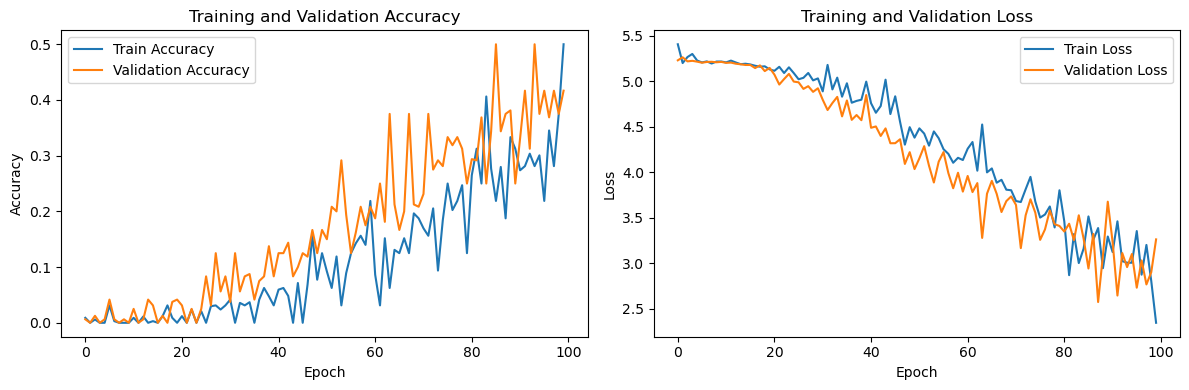

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step


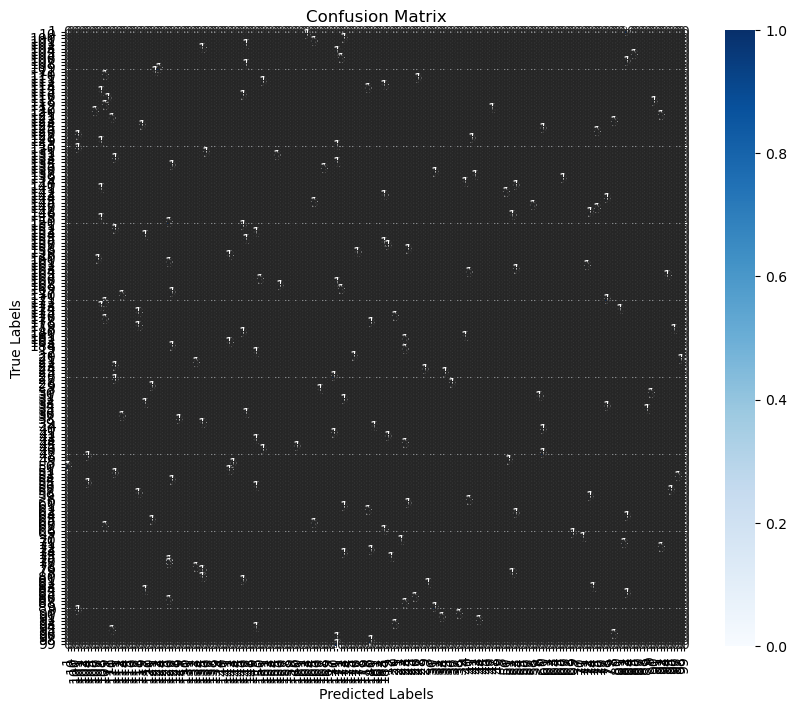

In [49]:
# Save the trained model

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to display the plots
plot_training_history(history)

# Generate confusion matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [53]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Make predictions on the test data
y_true = []  # True class labels
y_pred = []  # Predicted class labels

for i in range(len(test_generator)):  # Iterate over the test generator
    x_batch, y_batch_true = test_generator[i]  # Get the batch of data (features and true labels)
    y_batch_pred = model.predict(x_batch)  # Predict the labels
    y_true.extend(np.argmax(y_batch_true, axis=1))  # True labels
    y_pred.extend(np.argmax(y_batch_pred, axis=1))  # Predicted labels

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, and F1 scores
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Optionally, you can calculate precision, recall, and F1 scores separately:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
         100       0.00      0.00      0.00         1
         101       0.00      0.00      0.00         1
         102       0.00      0.00      0.00         1
         103       0.00      0.00      0.00         1
         104       0.50      1.00      0.67         1
         105       0.00      0.00      0.00         1
         106       1.00      1.00      1.00         1
         107       1.00      1.00      1.00         1
         108       0.20      1.00      0.33         1
         109       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
         

C:\Users\muham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\muham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\muham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\muham\anaconda3\Lib\site-packag

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted class: 2


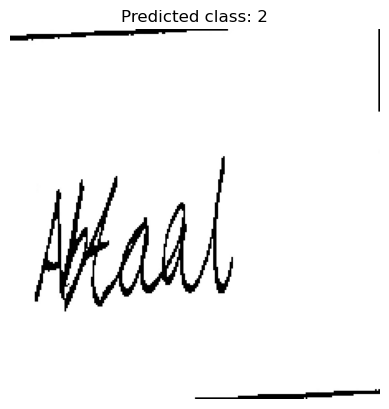

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('signature_classification_model.h5')

# Define the path to the image you want to classify
image_path = 'Processed_Images_Train/2/2_B.jpg'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target size to match the model input size
img_array = image.img_to_array(img)  # Convert the image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image (same as during training)

# Make predictions
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)  # Get the index of the highest score
class_labels = list(train_generator.class_indices.keys())  # Get class labels from your generator or manually set them
predicted_class_label = class_labels[predicted_class_index]

# Output the predicted class
print(f"Predicted class: {predicted_class_label}")

# Display the image along with its predicted label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from skimage import io, color
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
# Set a fixed length for the feature vectors (you can adjust this based on the size of the extracted features)
FIXED_FEATURE_LENGTH = 5000  # Adjust based on your experiment

# Function to pad or truncate feature vectors
def pad_or_truncate(features, fixed_length):
    if len(features) >= fixed_length:
        return features[:fixed_length]  # Truncate
    else:
        return np.pad(features, (0, fixed_length - len(features)), 'constant')  # Pad with zeros

# Function to extract HOG features from an image
def extract_hog_features(image_path):
    image = io.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
    features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return pad_or_truncate(features, FIXED_FEATURE_LENGTH)

# Function to extract SIFT features
def extract_sift_features(image_path):
    sift = cv2.SIFT_create()
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return pad_or_truncate(descriptors.flatten(), FIXED_FEATURE_LENGTH)
    else:
        return np.zeros(FIXED_FEATURE_LENGTH)  # Return zero vector if no descriptors are found

# Function to get image paths and labels from a directory
def get_image_paths_and_labels(directory):
    image_paths_and_labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            label = class_names.index(class_name)
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    image_paths_and_labels.append((img_path, label))
    return image_paths_and_labels


In [ ]:
# Prepare data for HOG and SIFT feature extraction
train_dir = 'Processed_Images_Train'
test_dir = 'Processed_Images_Test'
train_image_paths_and_labels = get_image_paths_and_labels(train_dir)
test_image_paths_and_labels = get_image_paths_and_labels(test_dir)

train_hog_features, train_sift_features = [], []
train_hog_labels, train_sift_labels = [], []

test_hog_features, test_sift_features = [], []
test_hog_labels, test_sift_labels = [], []

In [ ]:
# Process HOG features for the training set
for image_path, label in train_image_paths_and_labels:
    hog_features = extract_hog_features(image_path)  # Extract HOG features from the image
    if len(hog_features) > 0:  # If features are extracted successfully
        train_hog_features.append(hog_features)  # Add the features to the training HOG feature list
        train_hog_labels.append(label)  # Add the corresponding label to the training labels

# Process HOG features for the test set
for image_path, label in test_image_paths_and_labels:
    hog_features = extract_hog_features(image_path)  # Extract HOG features from the image
    if len(hog_features) > 0:  # If features are extracted successfully
        test_hog_features.append(hog_features)  # Add the features to the test HOG feature list
        test_hog_labels.append(label)  # Add the corresponding label to the test labels

# Process SIFT features for the training set
for image_path, label in train_image_paths_and_labels:
    sift_features = extract_sift_features(image_path)  # Extract SIFT features from the image
    if len(sift_features) > 0:  # If descriptors are found and extracted successfully
        train_sift_features.append(sift_features)  # Add the features to the training SIFT feature list
        train_sift_labels.append(label)  # Add the corresponding label to the training labels

# Process SIFT features for the test set
for image_path, label in test_image_paths_and_labels:
    sift_features = extract_sift_features(image_path)  # Extract SIFT features from the image
    if len(sift_features) > 0:  # If descriptors are found and extracted successfully
        test_sift_features.append(sift_features)  # Add the features to the test SIFT feature list
        test_sift_labels.append(label)  # Add the corresponding label to the test labels


In [ ]:
# Convert lists to numpy arrays
train_hog_features = np.array(train_hog_features)
train_hog_labels = np.array(train_hog_labels)
test_hog_features = np.array(test_hog_features)
test_hog_labels = np.array(test_hog_labels)

train_sift_features = np.array(train_sift_features)
train_sift_labels = np.array(train_sift_labels)
test_sift_features = np.array(test_sift_features)
test_sift_labels = np.array(test_sift_labels)

In [ ]:
# Convert labels to one-hot encoded format
train_hog_labels = to_categorical(train_hog_labels, num_classes=184)
test_hog_labels = to_categorical(test_hog_labels, num_classes=184)

train_sift_labels = to_categorical(train_sift_labels, num_classes=184)
test_sift_labels = to_categorical(test_sift_labels, num_classes=184)

In [ ]:
# Define a simple ANN model
def build_ann_model(input_size):
    ann_model = Sequential([
        Input(shape=(input_size,)),  # Using Input layer to avoid the warning
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(184, activation='softmax')
    ])
    ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return ann_model

In [75]:
# Train the ANN (Artificial Neural Network) using HOG features
hog_ann_model = build_ann_model(train_hog_features.shape[1])  # Build the ANN model with the input size equal to the HOG feature length
hog_ann_model.fit(train_hog_features, train_hog_labels, epochs=100, batch_size=32, 
validation_data=(test_hog_features, test_hog_labels), verbose=1)  # Train the model with HOG features, running for 100 epochs and using a batch size of 32. 
# The test data is used for validation.

# Train the ANN using SIFT features
sift_ann_model = build_ann_model(train_sift_features.shape[1])  # Build the ANN model with the input size equal to the SIFT feature length
sift_ann_model.fit(train_sift_features, train_sift_labels, epochs=100, batch_size=32, 
validation_data=(test_sift_features, test_sift_labels), verbose=1)  # Train the model with SIFT features, using the same configuration as the HOG model.

# Evaluate both models on test data
hog_test_loss, hog_test_acc = hog_ann_model.evaluate(test_hog_features, test_hog_labels)  # Evaluate the HOG-based model using the test set, return loss and accuracy
print(f'HOG Test accuracy: {hog_test_acc}')  # Print the test accuracy of the HOG-based model

sift_test_loss, sift_test_acc = sift_ann_model.evaluate(test_sift_features, test_sift_labels)  # Evaluate the SIFT-based model using the test set, return loss and accuracy
print(f'SIFT Test accuracy: {sift_test_acc}')  # Print the test accuracy of the SIFT-based model


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0053 - loss: 5.2224 - val_accuracy: 0.0054 - val_loss: 5.1962
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0415 - loss: 5.1290 - val_accuracy: 0.0054 - val_loss: 5.1731
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0651 - loss: 5.0188 - val_accuracy: 0.0054 - val_loss: 5.1580
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0738 - loss: 4.8961 - val_accuracy: 0.0163 - val_loss: 5.1440
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0656 - loss: 4.6832 - val_accuracy: 0.0163 - val_loss: 5.1601
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1452 - loss: 4.4403 - val_accuracy: 0.0217 - val_loss: 5.2261
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1484 - loss: 4.2627 - val_accuracy: 0.0217 - val_loss: 5.2930
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2266 - loss: 3.9917 - val_accuracy: 0.